# Qwen2.5-VL Video Analysis - Comprehension Video Locale

**Module :** 01-Video-Foundation  
**Niveau :** Intermediaire  
**Technologies :** Qwen2.5-VL 7B, transformers, torch  
**Duree estimee :** 50 minutes  
**VRAM :** ~18 GB (degradation possible sur GPU plus petits)  

## Objectifs d'Apprentissage

- [ ] Charger le modele Qwen2.5-VL-7B-Instruct localement avec transformers
- [ ] Comprendre le video understanding avec echantillonnage FPS dynamique
- [ ] Realiser une analyse frame par frame
- [ ] Effectuer du temporal grounding (localiser des evenements avec timestamps)
- [ ] Extraire du texte (OCR) dans les frames video
- [ ] Comparer les performances avec GPT-5 API (qualite, vitesse, cout)

## Prerequis

- GPU avec 18+ GB VRAM (RTX 3090, RTX 4090, A100)
- Notebook 01-2 (GPT-5 Video Understanding) complete
- Packages : `transformers>=4.45`, `torch`, `qwen-vl-utils`, `decord`, `accelerate`

> **Note** : Si votre GPU a moins de 18 GB de VRAM, le notebook tentera un chargement
> en precision reduite (bfloat16 ou int8). Les resultats peuvent varier.

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres modele
model_name = "Qwen/Qwen2.5-VL-7B-Instruct"  # Modele Hugging Face
device = "cuda"                    # "cuda" ou "cpu" (tres lent)
torch_dtype = "bfloat16"           # "bfloat16", "float16", "auto"
max_frames = 16                    # Nombre max de frames pour le modele

# Configuration video de test
sample_fps = 24
sample_duration = 10

# Configuration analyse
run_analysis = True                # Executer les analyses (False pour validation)
run_ocr = True                     # Tester l'OCR video
run_temporal_grounding = True      # Tester le temporal grounding
save_results = True

In [2]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw
from io import BytesIO
import matplotlib.pyplot as plt
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.genai_helpers import setup_genai_logging
        print("Helpers GenAI importes")
    except ImportError:
        print("Helpers GenAI non disponibles - mode autonome")

OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video_qwen_vl'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('video_qwen_vl')

print(f"Qwen2.5-VL Video Analysis")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, Modele : {model_name}")
print(f"Max frames : {max_frames}, Device : {device}")

Helpers GenAI importes
Qwen2.5-VL Video Analysis
Date : 2026-02-18 11:03:36
Mode : interactive, Modele : Qwen/Qwen2.5-VL-7B-Instruct
Max frames : 16, Device : cuda


In [3]:
# Chargement .env et verification GPU
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve")

# Verification GPU et VRAM
print("\n--- VERIFICATION GPU ---")
print("=" * 40)

import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram_total = torch.cuda.get_device_properties(0).total_mem / 1024**3
    vram_free = (torch.cuda.get_device_properties(0).total_mem - torch.cuda.memory_allocated(0)) / 1024**3
    
    print(f"GPU : {gpu_name}")
    print(f"VRAM totale : {vram_total:.1f} GB")
    print(f"VRAM libre : {vram_free:.1f} GB")
    print(f"CUDA : {torch.version.cuda}")
    print(f"PyTorch : {torch.__version__}")
    
    if vram_total < 18:
        print(f"\nAttention : VRAM ({vram_total:.0f} GB) < 18 GB recommandes")
        print("Le modele sera charge en precision reduite si possible")
        if vram_total < 8:
            print("VRAM insuffisante. Passage en mode CPU (tres lent).")
            device = "cpu"
elif device == "cuda":
    print("CUDA non disponible. Passage en mode CPU (tres lent).")
    device = "cpu"
else:
    print(f"Mode CPU selectionne (pas de GPU)")

print(f"\nDevice final : {device}")
print(f"Precision : {torch_dtype}")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION GPU ---


CUDA non disponible. Passage en mode CPU (tres lent).

Device final : cpu
Precision : bfloat16


## Section 1 : Chargement du modele Qwen2.5-VL

Qwen2.5-VL est un modele vision-langage capable de comprendre des videos nativement.
Contrairement a GPT-5 qui recoit des frames statiques, Qwen-VL peut traiter une
sequence de frames avec une notion de temporalite integree.

| Modele | Parametres | VRAM | Contexte video |
|--------|-----------|------|----------------|
| Qwen2.5-VL-2B | 2B | ~6 GB | Basique |
| Qwen2.5-VL-7B | 7B | ~18 GB | Avance |
| Qwen2.5-VL-72B | 72B | ~150 GB | Etat de l'art |

In [4]:
# Chargement du modele Qwen2.5-VL
print("\n--- CHARGEMENT DU MODELE ---")
print("=" * 40)

model = None
processor = None

if run_analysis:
    try:
        from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
        
        # Selection de la precision selon la VRAM
        dtype_map = {
            "bfloat16": torch.bfloat16,
            "float16": torch.float16,
            "auto": "auto"
        }
        selected_dtype = dtype_map.get(torch_dtype, torch.bfloat16)
        
        print(f"Chargement de {model_name}...")
        print(f"  Precision : {torch_dtype}")
        print(f"  Device : {device}")
        start_load = time.time()
        
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=selected_dtype,
            device_map="auto" if device == "cuda" else None,
            attn_implementation="flash_attention_2" if device == "cuda" else "eager"
        )
        
        processor = AutoProcessor.from_pretrained(model_name)
        
        load_time = time.time() - start_load
        
        if device == "cuda":
            vram_used = torch.cuda.memory_allocated(0) / 1024**3
            print(f"  VRAM utilisee : {vram_used:.1f} GB")
        
        print(f"Modele charge en {load_time:.1f}s")
        
    except Exception as e:
        print(f"Erreur chargement modele : {type(e).__name__}: {str(e)[:150]}")
        print("Le notebook continuera sans executer les analyses.")
        run_analysis = False
        run_ocr = False
        run_temporal_grounding = False
else:
    print("Chargement modele desactive (run_analysis=False)")


--- CHARGEMENT DU MODELE ---


Erreur chargement modele : ImportError: huggingface-hub>=0.30.0,<1.0 is required for a normal functioning of this module, but found huggingface-hub==1.4.1.
Try: `pip install transformers -U`
Le notebook continuera sans executer les analyses.


## Section 2 : Creation de la video de test et analyse

Nous reutilisons le meme type de video multi-scenes que dans le notebook 01-2
pour pouvoir comparer les resultats entre GPT-5 et Qwen-VL. En ajoutant du texte
lisible dans les frames, nous pourrons aussi tester les capacites OCR.


--- CREATION VIDEO DE TEST ---


Video creee : test_qwen_analysis.mp4
  5 scenes, 240 frames, 10.0s

Evenements temporels (verite terrain) :
  titre_apparait : t=0.0s
  chapitre_ml : t=2.0s
  formule_visible : t=4.0s
  resultat_affiche : t=6.0s
  fin_presentation : t=8.0s


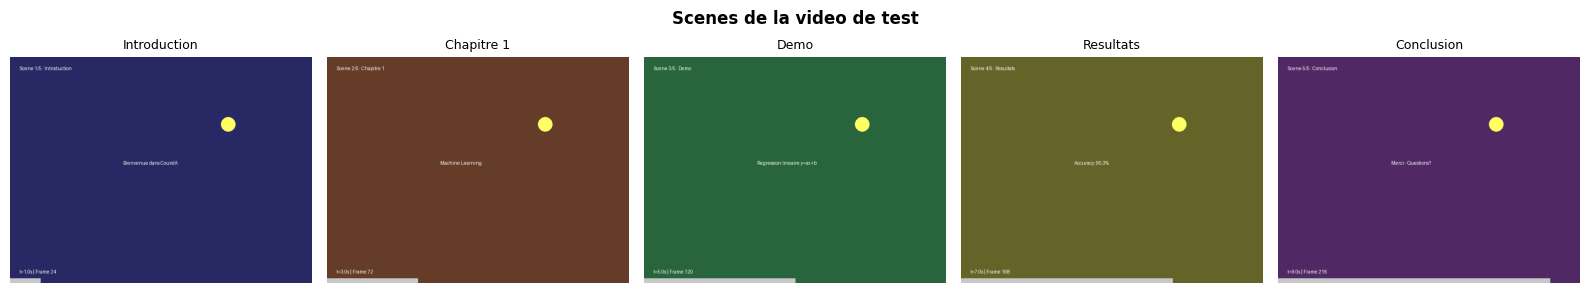

In [5]:
# Creation video de test avec texte OCR et evenements temporels
import imageio

print("\n--- CREATION VIDEO DE TEST ---")
print("=" * 40)

scenes = [
    {"name": "Introduction", "bg": (40, 40, 100), "text": "Bienvenue dans CoursIA",
     "event": "titre_apparait"},
    {"name": "Chapitre 1", "bg": (100, 60, 40), "text": "Machine Learning",
     "event": "chapitre_ml"},
    {"name": "Demo", "bg": (40, 100, 60), "text": "Regression lineaire y=ax+b",
     "event": "formule_visible"},
    {"name": "Resultats", "bg": (100, 100, 40), "text": "Accuracy: 95.3%",
     "event": "resultat_affiche"},
    {"name": "Conclusion", "bg": (80, 40, 100), "text": "Merci - Questions?",
     "event": "fin_presentation"},
]

width, height = 640, 480
frames_per_scene = sample_fps * sample_duration // len(scenes)
all_frames = []
event_timestamps = {}

for scene_idx, scene in enumerate(scenes):
    event_timestamps[scene['event']] = scene_idx * frames_per_scene / sample_fps
    
    for frame_i in range(frames_per_scene):
        t = frame_i / frames_per_scene
        global_frame = scene_idx * frames_per_scene + frame_i
        global_t = global_frame / sample_fps
        
        img = Image.new('RGB', (width, height), scene['bg'])
        draw = ImageDraw.Draw(img)
        
        # Barre de progression en bas
        progress = global_frame / (frames_per_scene * len(scenes))
        draw.rectangle([0, height-10, int(width * progress), height], fill=(200, 200, 200))
        
        # Texte principal (pour OCR)
        draw.text((width // 2 - 80, height // 2 - 20), scene['text'], fill='white')
        
        # Numero de scene
        draw.text((20, 20), f"Scene {scene_idx + 1}/5 : {scene['name']}", fill='white')
        draw.text((20, height - 30), f"t={global_t:.1f}s | Frame {global_frame}", fill='white')
        
        # Cercle anime
        cx = int(width * 0.8 + 50 * np.cos(2 * np.pi * t))
        cy = int(height * 0.3 + 30 * np.sin(2 * np.pi * t))
        draw.ellipse([cx-15, cy-15, cx+15, cy+15], fill=(255, 255, 100))
        
        all_frames.append(np.array(img))

# Sauvegarde
test_video_path = OUTPUT_DIR / "test_qwen_analysis.mp4"
writer = imageio.get_writer(str(test_video_path), fps=sample_fps, codec='libx264')
for frame in all_frames:
    writer.append_data(frame)
writer.close()

print(f"Video creee : {test_video_path.name}")
print(f"  {len(scenes)} scenes, {len(all_frames)} frames, {len(all_frames)/sample_fps:.1f}s")
print(f"\nEvenements temporels (verite terrain) :")
for event, ts in event_timestamps.items():
    print(f"  {event} : t={ts:.1f}s")

# Apercu
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
for i, ax in enumerate(axes):
    idx = i * frames_per_scene + frames_per_scene // 2
    ax.imshow(all_frames[idx])
    ax.set_title(scenes[i]['name'], fontsize=9)
    ax.axis('off')
plt.suptitle("Scenes de la video de test", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Analyse video avec Qwen2.5-VL
print("\n--- ANALYSE VIDEO QWEN2.5-VL ---")
print("=" * 45)

def analyze_video_qwen(video_path: str, prompt: str,
                       max_frames: int = 16) -> Dict[str, Any]:
    """
    Analyse une video avec Qwen2.5-VL.
    
    Args:
        video_path: Chemin vers le fichier video
        prompt: Question ou instruction d'analyse
        max_frames: Nombre max de frames a traiter
    
    Returns:
        Dict avec analyse, temps de traitement et VRAM
    """
    if model is None or processor is None:
        return {"success": False, "error": "Modele non charge"}
    
    try:
        # Construction du message avec video
        messages = [{
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": str(video_path),
                    "max_pixels": 360 * 420,
                    "fps": 1.0  # 1 frame par seconde pour economiser la VRAM
                },
                {"type": "text", "text": prompt}
            ]
        }]
        
        # Preparation des inputs
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        
        from qwen_vl_utils import process_vision_info
        image_inputs, video_inputs = process_vision_info(messages)
        
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt"
        ).to(model.device)
        
        # Generation
        if device == "cuda":
            vram_before = torch.cuda.memory_allocated(0) / 1024**3
        
        start_time = time.time()
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=512
            )
        gen_time = time.time() - start_time
        
        # Decodage
        generated_ids = output_ids[:, inputs['input_ids'].shape[1]:]
        response_text = processor.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0]
        
        result = {
            "success": True,
            "analysis": response_text,
            "generation_time": gen_time,
            "output_tokens": generated_ids.shape[1],
        }
        
        if device == "cuda":
            vram_after = torch.cuda.memory_allocated(0) / 1024**3
            result["vram_peak"] = torch.cuda.max_memory_allocated(0) / 1024**3
            result["vram_delta"] = vram_after - vram_before
        
        return result
        
    except Exception as e:
        return {"success": False, "error": f"{type(e).__name__}: {str(e)[:200]}"}


# Analyse 1 : Description globale
if run_analysis:
    print("Analyse 1 : Description globale")
    result_global = analyze_video_qwen(
        test_video_path,
        "Decris cette video en francais. Identifie les differentes scenes, "
        "les elements visuels principaux et la progression temporelle."
    )
    
    if result_global['success']:
        print(f"  Temps : {result_global['generation_time']:.1f}s")
        print(f"  Tokens generes : {result_global['output_tokens']}")
        if 'vram_peak' in result_global:
            print(f"  VRAM pic : {result_global['vram_peak']:.1f} GB")
        print(f"\n--- Analyse Qwen-VL ---")
        print(result_global['analysis'])
    else:
        print(f"  Erreur : {result_global['error']}")
else:
    print("Analyse desactivee")
    result_global = {"success": False}


--- ANALYSE VIDEO QWEN2.5-VL ---
Analyse desactivee


In [7]:
# OCR video et temporal grounding
results_ocr = {"success": False}
results_grounding = {"success": False}

if run_ocr and run_analysis:
    print("\n--- OCR VIDEO ---")
    print("=" * 40)
    
    results_ocr = analyze_video_qwen(
        test_video_path,
        "Lis tout le texte visible dans cette video. Pour chaque texte trouve, "
        "indique a quel moment il apparait et ce qu'il dit exactement."
    )
    
    if results_ocr['success']:
        print(f"  Temps : {results_ocr['generation_time']:.1f}s")
        print(f"\n--- OCR Resultats ---")
        print(results_ocr['analysis'])
    else:
        print(f"  Erreur OCR : {results_ocr['error']}")

if run_temporal_grounding and run_analysis:
    print("\n--- TEMPORAL GROUNDING ---")
    print("=" * 40)
    
    results_grounding = analyze_video_qwen(
        test_video_path,
        "Dans cette video, identifie precisement les moments suivants :\n"
        "1. Quand le titre apparait pour la premiere fois\n"
        "2. Quand une formule mathematique est visible\n"
        "3. Quand un resultat de precision (accuracy) est affiche\n"
        "Donne les timestamps au format [debut - fin] en secondes."
    )
    
    if results_grounding['success']:
        print(f"  Temps : {results_grounding['generation_time']:.1f}s")
        print(f"\n--- Temporal Grounding ---")
        print(results_grounding['analysis'])
        
        # Comparaison avec la verite terrain
        print(f"\nVerite terrain (timestamps reels) :")
        for event, ts in event_timestamps.items():
            print(f"  {event} : t={ts:.1f}s")
    else:
        print(f"  Erreur grounding : {results_grounding['error']}")

In [8]:
# Mode interactif
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Posez une question sur la video de test a Qwen-VL.")
    print("(Laissez vide pour passer a la suite)")
    
    try:
        user_question = input("\nVotre question : ").strip()
        
        if user_question and run_analysis:
            result_user = analyze_video_qwen(test_video_path, user_question)
            if result_user['success']:
                print(f"\nReponse Qwen-VL :")
                print(result_user['analysis'])
                print(f"\n({result_user['generation_time']:.1f}s, {result_user['output_tokens']} tokens)")
            else:
                print(f"Erreur : {result_user['error']}")
        elif not user_question:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError) as e:
        print(f"\nMode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\nMode interactif non disponible (execution automatisee)")
        else:
            print(f"\nErreur inattendue : {error_type} - {str(e)[:100]}")
            print("Passage a la suite du notebook")
else:
    print("\nMode batch - Interface interactive desactivee")


--- MODE INTERACTIF ---
Posez une question sur la video de test a Qwen-VL.
(Laissez vide pour passer a la suite)

Mode interactif non disponible (execution automatisee)


## Comparaison GPT-5 vs Qwen2.5-VL

| Critere | GPT-5 (API) | Qwen2.5-VL (local) |
|---------|-------------|--------------------|
| **Acces** | API cloud (cle requise) | Local (GPU requis) |
| **VRAM** | 0 (cloud) | ~18 GB |
| **Latence** | 2-10s (reseau) | 5-30s (GPU) |
| **Cout** | ~$0.01-0.05/analyse | Gratuit apres setup |
| **Confidentialite** | Donnees envoyees au cloud | 100% local |
| **Video native** | Non (frames statiques) | Oui (temporal attention) |
| **OCR** | Bon | Bon |
| **Temporal grounding** | Approximatif | Natif |

**Recommandations** :
- Utilisez **GPT-5** pour du prototypage rapide ou sans GPU
- Utilisez **Qwen-VL** pour du traitement en volume ou des donnees sensibles
- Pour la production, evaluez sur votre cas d'usage specifique

In [9]:
# Statistiques de session et prochaines etapes
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Modele : {model_name}")
print(f"Device : {device}")

if device == "cuda" and torch.cuda.is_available():
    vram_used = torch.cuda.memory_allocated(0) / 1024**3
    vram_peak = torch.cuda.max_memory_allocated(0) / 1024**3
    print(f"VRAM actuelle : {vram_used:.1f} GB")
    print(f"VRAM pic : {vram_peak:.1f} GB")

analyses_done = sum([
    result_global.get('success', False),
    results_ocr.get('success', False),
    results_grounding.get('success', False)
])
print(f"Analyses reussies : {analyses_done}/3")

if save_results:
    results_data = {
        "model": model_name,
        "device": device,
        "global_analysis": result_global if result_global.get('success') else None,
        "ocr": results_ocr if results_ocr.get('success') else None,
        "temporal_grounding": results_grounding if results_grounding.get('success') else None,
        "timestamp": datetime.now().isoformat()
    }
    results_file = OUTPUT_DIR / f"qwen_vl_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(results_data, f, indent=2, ensure_ascii=False, default=str)
    print(f"Resultats sauvegardes : {results_file.name}")

# Liberation VRAM
if model is not None:
    del model
    del processor
    if device == "cuda":
        torch.cuda.empty_cache()
        print(f"VRAM liberee")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 01-4 : Amelioration video avec Real-ESRGAN (upscaling, interpolation)")
print(f"2. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)")
print(f"3. Module 02 : Modeles generatifs video avances (HunyuanVideo, LTX-Video)")

print(f"\nNotebook 01-3 Qwen-VL Video Analysis termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-18 11:03:39
Modele : Qwen/Qwen2.5-VL-7B-Instruct
Device : cpu
Analyses reussies : 0/3
Resultats sauvegardes : qwen_vl_analysis_20260218_110339.json

--- PROCHAINES ETAPES ---
1. Notebook 01-4 : Amelioration video avec Real-ESRGAN (upscaling, interpolation)
2. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)
3. Module 02 : Modeles generatifs video avances (HunyuanVideo, LTX-Video)

Notebook 01-3 Qwen-VL Video Analysis termine - 11:03:39
